# Models

MutinomialNB with TfidVectorizer on Original Dataset 

- cleaned: accuracy - 0.65

- cleaned and stemmed: accuracy - 0.69

- cleaned and lemmized: accuracy - 0.70

MutinomialNB with CountVectorizer on Original Dataset 

- cleaned: accuracy - 0.77

- cleaned and stemmed: accuracy - 0.77

- cleaned and lemmized: accuracy - 0.80

- cleaned and dropped surprised label: accuracy - 0.83 (Best Model on Original Dataset)

MutinomialNB with TfidVectorizer on Original Dataset 

- cleaned: accuracy - 0.87

- cleaned and stemmed: accuracy - 0.84

- cleaned and lemmized: accuracy - 0.87

MutinomialNB with CountVectorizer on Second Dataset (First 10_000)

- cleaned: accuracy - 0.86

- cleaned and stemmed: accuracy - 0.84

- cleaned and lemmized: accuracy - 0.88 (Best Model on Second Dataset) (Live Model)

# Importing Python Libraries

In [1]:
# Import File Based Libraries
import pickle

# Import Data Wrangling Libraries
import pandas as pd
import numpy as np 
import re

# Import Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Machine Learning Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

# Import NLP Libraries
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Creating Dataframes from Original Dataset

In [2]:
#split up data with train and test 
train_df = pd.read_csv("data/original_data/training.csv")
test_df = pd.read_csv("data/original_data/test.csv")

train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


# EDA on Original Dataset

In [3]:
#find nulls
display(train_df.isnull().sum())
display(test_df.isnull().sum())

#find dups
display(train_df.duplicated().sum())
display(test_df.duplicated().sum())


text     0
label    0
dtype: int64

text     0
label    0
dtype: int64

1

0

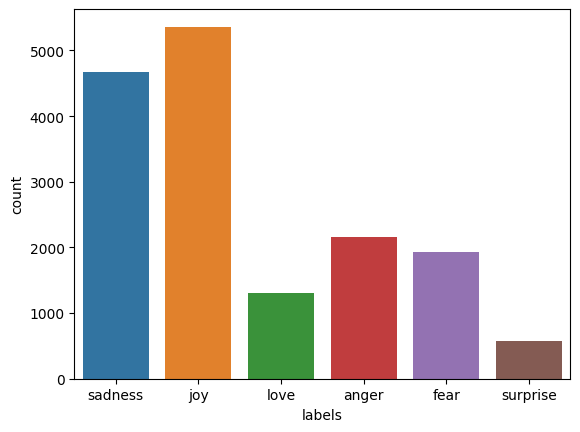

In [4]:
#label distribution for train split
sns.countplot(x=train_df['label'])
plt.xticks([x for x in range(6)], ["sadness", "joy", "love", "anger", "fear", "surprise"])
plt.xlabel("labels")
plt.show()

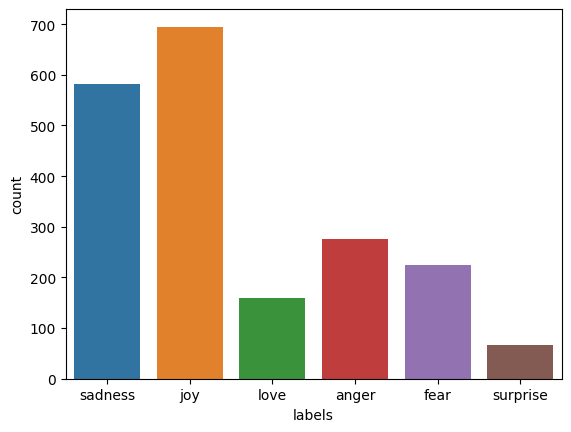

In [5]:
#label distribution for test split
sns.countplot(x=test_df['label'])
plt.xticks([x for x in range(6)], ["sadness", "joy", "love", "anger", "fear", "surprise"])
plt.xlabel("labels")
plt.show()

# EDA Conclusion

> There is a uneven distribution of our labels in both train and test split of the data therefore there will be bias in our model for the labels that have a higher count: sadness and joy. Some possible ways to combated this issue would be to get more data to the point where our labels are close to have the same amount for both splits or dropping the labels that aren't going to well: surprise label. 

# Creating Helper Functions

In [6]:
#helper function
def clean_tweets_without_nlp(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    tweet = " ".join([ word for word in words])
    return tweet

def clean_tweets_with_stem(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    tweet = " ".join([word for word in words if word not in stopwords.words('english') ])
    words = word_tokenize(tweet)
    porter = PorterStemmer()
    tweet = " ".join([ porter.stem(word) for word in words])
    return tweet

def clean_tweets_with_lem(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    tweet = " ".join([word for word in words if word not in stopwords.words('english') ])
    words = word_tokenize(tweet)
    lem = WordNetLemmatizer()
    tweet = " ".join([ lem.lemmatize(word) for word in words])
    return tweet

#apply helper function
train_df['cleaned_text'] = train_df['text'].apply(clean_tweets_without_nlp)
test_df['cleaned_text'] = test_df['text'].apply(clean_tweets_without_nlp)

train_df['cleaned_text_stem'] = train_df['text'].apply(clean_tweets_with_stem)
test_df['cleaned_text_stem'] = test_df['text'].apply(clean_tweets_with_stem)

train_df['cleaned_text_lem'] = train_df['text'].apply(clean_tweets_with_lem)
test_df['cleaned_text_lem'] = test_df['text'].apply(clean_tweets_with_lem)

In [7]:
#current dataframes
train_df.head()

,text,label,cleaned_text,cleaned_text_stem,cleaned_text_lem
0,i didnt feel humiliated,0,i didnt feel humiliated,didnt feel humili,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,i can go from feeling so hopeless to so damned...,go feel hopeless damn hope around someon care ...,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,3,im grabbing a minute to post i feel greedy wrong,im grab minut post feel greedi wrong,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,i am ever feeling nostalgic about the fireplac...,ever feel nostalg fireplac know still properti,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,3,i am feeling grouchy,feel grouchi,feeling grouchy


# Testing with TfidfVectorizer and Multinomial Naive Bayes Classifier on Original Dataset

cleaned_text


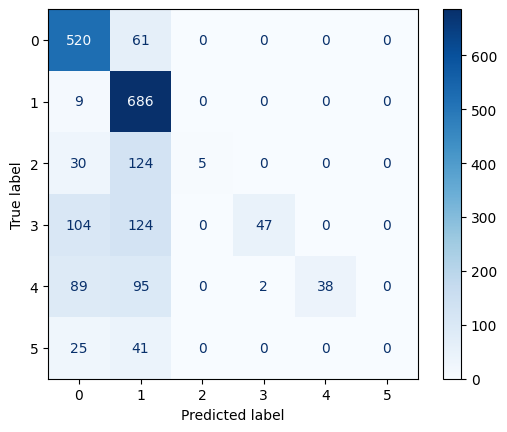

              precision    recall  f1-score   support

     sadness       0.67      0.90      0.77       581
         joy       0.61      0.99      0.75       695
        love       1.00      0.03      0.06       159
       anger       0.96      0.17      0.29       275
        fear       1.00      0.17      0.29       224
    surprise       1.00      0.00      0.00        66

    accuracy                           0.65      2000
   macro avg       0.87      0.38      0.36      2000
weighted avg       0.76      0.65      0.56      2000




cleaned_text_stem


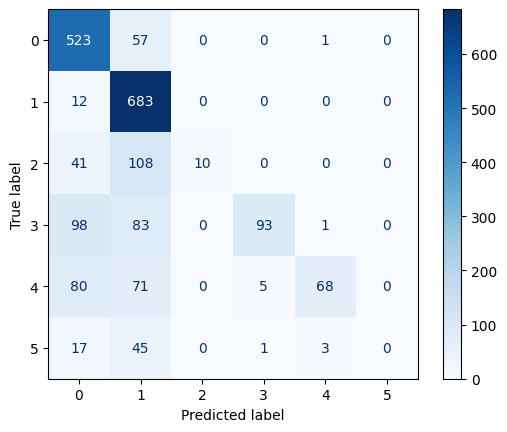

              precision    recall  f1-score   support

     sadness       0.68      0.90      0.77       581
         joy       0.65      0.98      0.78       695
        love       1.00      0.06      0.12       159
       anger       0.94      0.34      0.50       275
        fear       0.93      0.30      0.46       224
    surprise       1.00      0.00      0.00        66

    accuracy                           0.69      2000
   macro avg       0.87      0.43      0.44      2000
weighted avg       0.77      0.69      0.63      2000




cleaned_text_lem


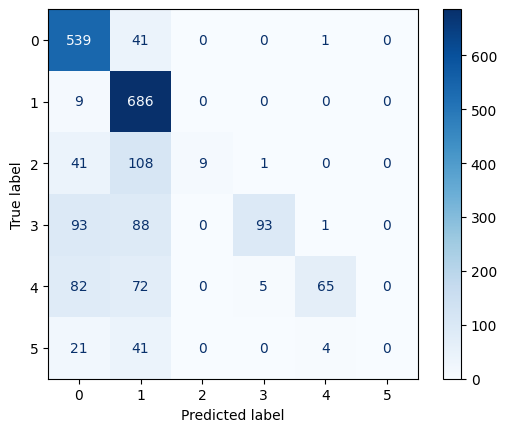

              precision    recall  f1-score   support

     sadness       0.69      0.93      0.79       581
         joy       0.66      0.99      0.79       695
        love       1.00      0.06      0.11       159
       anger       0.94      0.34      0.50       275
        fear       0.92      0.29      0.44       224
    surprise       1.00      0.00      0.00        66

    accuracy                           0.70      2000
   macro avg       0.87      0.43      0.44      2000
weighted avg       0.77      0.70      0.63      2000






In [8]:
# Tfidf Vectorized MNB Model

tfidf_models = []

for col in train_df.columns[2:]:

    print(col)

    #split features and label
    X_train = train_df[col]
    y_train = train_df['label']

    X_test = test_df[col]
    y_test = test_df['label']

    #Fit and Transform
    X_temp = pd.concat([X_train,X_test])
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X_temp)

    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)

    #Create model and predict
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Create confusion matrix for Tfid model
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # display metrics
    # metrics_df = {
    #     'precision_score' : precision_score(y_test, y_pred, average=None),
    #     'recall_score' : recall_score(y_test, y_pred, average=None),
    #     'f1_score' : f1_score(y_test, y_pred, average=None)
    # }

    # display(pd.DataFrame(metrics_df, index=['sadness','joy','love','anger','fear','surprise']))

    print(classification_report(y_test, model.predict(X_test), target_names=['sadness','joy','love','anger','fear','surprise'], zero_division=1))
    print("\n\n")

    package = [model, tfidf_vectorizer]
    tfidf_models.append(package)

# Testing with Bag of Words Vectorizer and Multinomial Naive Bayes Classifier

cleaned_text


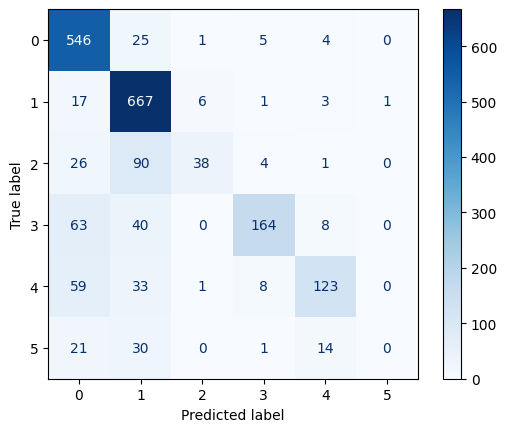

              precision    recall  f1-score   support

     sadness       0.75      0.94      0.83       581
         joy       0.75      0.96      0.84       695
        love       0.83      0.24      0.37       159
       anger       0.90      0.60      0.72       275
        fear       0.80      0.55      0.65       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.77      2000
   macro avg       0.67      0.55      0.57      2000
weighted avg       0.76      0.77      0.74      2000




cleaned_text_stem


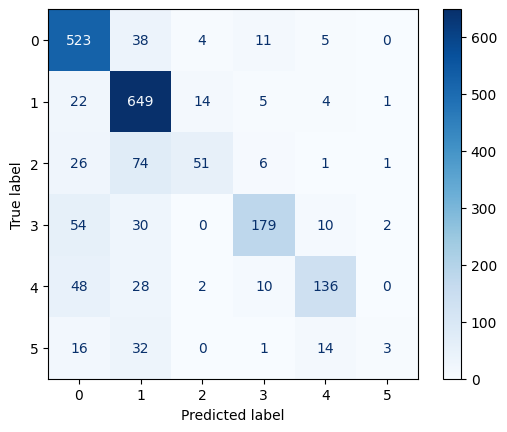

              precision    recall  f1-score   support

     sadness       0.76      0.90      0.82       581
         joy       0.76      0.93      0.84       695
        love       0.72      0.32      0.44       159
       anger       0.84      0.65      0.74       275
        fear       0.80      0.61      0.69       224
    surprise       0.43      0.05      0.08        66

    accuracy                           0.77      2000
   macro avg       0.72      0.58      0.60      2000
weighted avg       0.76      0.77      0.75      2000




cleaned_text_lem


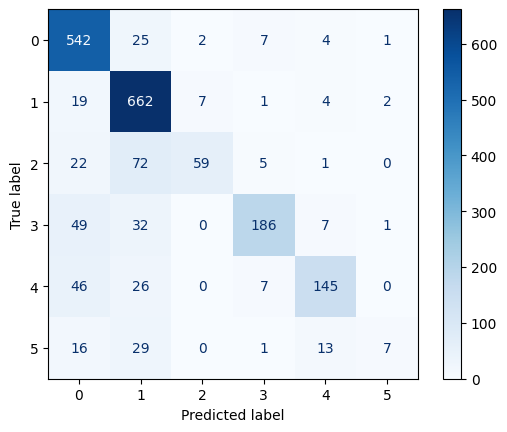

              precision    recall  f1-score   support

     sadness       0.78      0.93      0.85       581
         joy       0.78      0.95      0.86       695
        love       0.87      0.37      0.52       159
       anger       0.90      0.68      0.77       275
        fear       0.83      0.65      0.73       224
    surprise       0.64      0.11      0.18        66

    accuracy                           0.80      2000
   macro avg       0.80      0.61      0.65      2000
weighted avg       0.81      0.80      0.78      2000






In [9]:
#Bag of Words with MultinomialNB Model

BoW_models = []

for col in train_df.columns[2:]:

    print(col)

    #split features and label
    X_train = train_df[col]
    y_train = train_df['label']

    X_test = test_df[col]
    y_test = test_df['label']

    #Fit and Transform
    X_temp = pd.concat([X_train,X_test])
    BoW_vectorizer = CountVectorizer()
    BoW_vectorizer.fit(X_temp)

    X_train = BoW_vectorizer.transform(X_train)
    X_test = BoW_vectorizer.transform(X_test)

    #Create model and predict
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Create confusion matrix for BOW model
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    #display metrics
    print(classification_report(y_test, model.predict(X_test), target_names=['sadness','joy','love','anger','fear','surprise'], zero_division=1))
    print("\n\n")

    package = [model, BoW_vectorizer]
    BoW_models.append(package)

# Testing with Bag of Words Vectorizer and Multinomial Naive Bayes Classifier a Dataset with Surprise Label Dropped

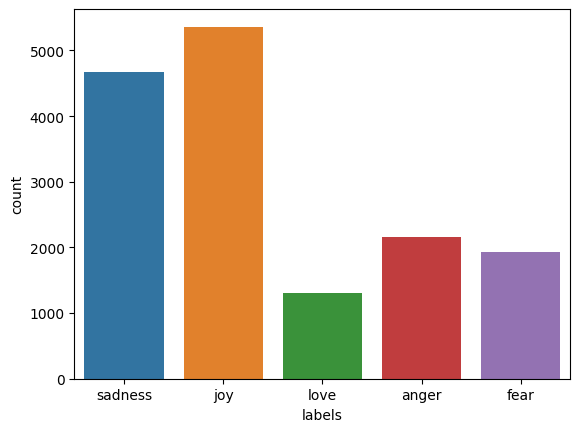

cleaned_text


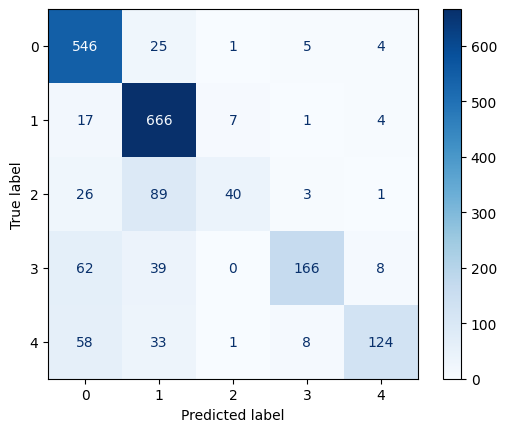

              precision    recall  f1-score   support

     sadness       0.77      0.94      0.85       581
         joy       0.78      0.96      0.86       695
        love       0.82      0.25      0.38       159
       anger       0.91      0.60      0.72       275
        fear       0.88      0.55      0.68       224

    accuracy                           0.80      1934
   macro avg       0.83      0.66      0.70      1934
weighted avg       0.81      0.80      0.78      1934

cleaned_text_stem


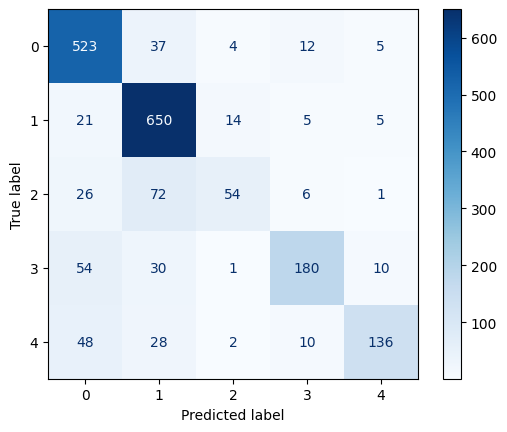

              precision    recall  f1-score   support

     sadness       0.78      0.90      0.83       581
         joy       0.80      0.94      0.86       695
        love       0.72      0.34      0.46       159
       anger       0.85      0.65      0.74       275
        fear       0.87      0.61      0.71       224

    accuracy                           0.80      1934
   macro avg       0.80      0.69      0.72      1934
weighted avg       0.80      0.80      0.79      1934

cleaned_text_lem


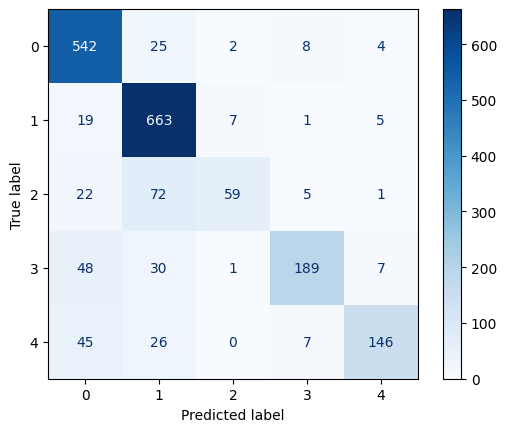

              precision    recall  f1-score   support

     sadness       0.80      0.93      0.86       581
         joy       0.81      0.95      0.88       695
        love       0.86      0.37      0.52       159
       anger       0.90      0.69      0.78       275
        fear       0.90      0.65      0.75       224

    accuracy                           0.83      1934
   macro avg       0.85      0.72      0.76      1934
weighted avg       0.83      0.83      0.82      1934



In [10]:
#Best Model with label 5 dropped

train_df_dropped_surprise = train_df.copy()
test_df_dropped_surprise = test_df.copy()

train_df_dropped_surprise = train_df_dropped_surprise[train_df_dropped_surprise['label'] != 5]
test_df_dropped_surprise = test_df_dropped_surprise[test_df_dropped_surprise['label'] != 5]

sns.countplot(x=train_df_dropped_surprise['label'])
plt.xticks([x for x in range(5)], ["sadness", "joy", "love", "anger", "fear"])
plt.xlabel("labels")
plt.show()

test_models = []

for col in train_df.columns[2:]:

    print(col)

    #split features and label
    X_train_dropped_surprise = train_df_dropped_surprise[col]
    y_train_dropped_surprise = train_df_dropped_surprise['label']

    X_test_dropped_surprise = test_df_dropped_surprise[col]
    y_test_dropped_surprise = test_df_dropped_surprise['label']

    #Fit and Transform
    X_temp = pd.concat([X_train_dropped_surprise,X_test_dropped_surprise])
    BoW_vectorizer = CountVectorizer()
    BoW_vectorizer.fit(X_temp)

    X_train_dropped_surprise = BoW_vectorizer.transform(X_train_dropped_surprise)
    X_test_dropped_surprise = BoW_vectorizer.transform(X_test_dropped_surprise)

    #Create model and predict
    model = MultinomialNB()
    model.fit(X_train_dropped_surprise, y_train_dropped_surprise)
    y_pred_dropped_surprise = model.predict(X_test_dropped_surprise)

    #Create confusion matrix for BOW model
    cm = confusion_matrix(y_test_dropped_surprise, y_pred_dropped_surprise, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    #display metrics
    print(classification_report(y_test_dropped_surprise, model.predict(X_test_dropped_surprise), target_names=['sadness','joy','love','anger','fear'], zero_division=1))

    package = [model, BoW_vectorizer]
    test_models.append(package)

# Best Models From Original Dataset

In [11]:
print("Bow and MNB on Full Dataset\n",classification_report(y_test,BoW_models[2][0].predict(X_test)),"\n")
print("Bow and MNB on Dropped Datasets\n",classification_report(y_test_dropped_surprise, test_models[2][0].predict(X_test_dropped_surprise)))

Bow and MNB on Full Dataset
               precision    recall  f1-score   support

           0       0.78      0.93      0.85       581
           1       0.78      0.95      0.86       695
           2       0.87      0.37      0.52       159
           3       0.90      0.68      0.77       275
           4       0.83      0.65      0.73       224
           5       0.64      0.11      0.18        66

    accuracy                           0.80      2000
   macro avg       0.80      0.61      0.65      2000
weighted avg       0.81      0.80      0.78      2000
 

Bow and MNB on Dropped Datasets
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       581
           1       0.81      0.95      0.88       695
           2       0.86      0.37      0.52       159
           3       0.90      0.69      0.78       275
           4       0.90      0.65      0.75       224

    accuracy                           0.83      1934
   macro avg 

# Saving Models from Orignial Dataset

In [12]:
# save best model 
# pickle.dump(BoW_models[0][0], open('cleaned_BoW-MNB.pkl', 'wb'))

# save vectorizer
# pickle.dump(BoW_models[0][1], open('BoW_vectorizer-MNB.pkl', 'wb'))

# Creating Dataframes from Second Dataset

In [13]:
data =pickle.load(open('data/second_data/merged_training.pkl','rb'))
new_df = pd.DataFrame(data).reset_index(drop=True)
new_df.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


# EDA on Second Dataset

<AxesSubplot: xlabel='emotions', ylabel='count'>

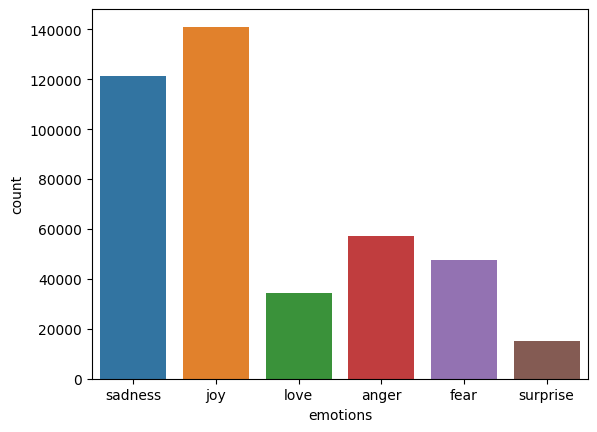

In [14]:
sns.countplot(x=new_df['emotions'])

In [15]:
new_df['emotions'].value_counts()

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

# Testing on Second Dataset with Bag of Words Vectorizer and Multinomial Naive Bayes Classifier

In [16]:
#Made a copy of the data frame
new_df_10000_2 = new_df.copy()

#Getting 10k Sadness
sadness_df = new_df_10000_2[new_df_10000_2['emotions'] == 'sadness']
sadness_df_10000 = sadness_df.iloc[:10000].reset_index(drop=True)
display(sadness_df_10000.shape)
display(sadness_df_10000.head())

#Getting 10k Joy
joy_df = new_df_10000_2[new_df_10000_2['emotions'] == 'joy']
joy_df_10000 = joy_df.iloc[:10000].reset_index(drop=True)
display(joy_df_10000.shape)
display(joy_df_10000.head())

#Getting 10k Love
love_df = new_df_10000_2[new_df_10000_2['emotions'] == 'love']
love_df_10000 = love_df.iloc[:10000].reset_index(drop=True)
display(love_df_10000.shape)
display(love_df_10000.head())

#Getting 10k Anger
anger_df = new_df_10000_2[new_df_10000_2['emotions'] == 'anger']
anger_df_10000 = anger_df.iloc[:10000].reset_index(drop=True)
display(anger_df_10000.shape)
display(anger_df_10000.head())

#Getting 10k Fear
fear_df = new_df_10000_2[new_df_10000_2['emotions'] == 'fear']
fear_df_10000 = fear_df.iloc[:10000].reset_index(drop=True)
display(fear_df_10000.shape)
display(fear_df_10000.head())

#Getting 10k Surprise
surprise_df = new_df_10000_2[new_df_10000_2['emotions'] == 'surprise']
surprise_df_10000 = surprise_df.iloc[:10000].reset_index(drop=True)
display(surprise_df_10000.shape)
display(surprise_df_10000.head())

(10000, 2)

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,i was feeling a little low few days back,sadness
3,i also feel disillusioned that someone who cla...,sadness
4,i wish you knew every word i write i write for...,sadness


(10000, 2)

,text,emotions
0,ive probably mentioned this before but i reall...,joy
1,i am one of those people who feels like going ...,joy
2,i feel especially pleased about this as this h...,joy
3,i was struggling with these awful feelings and...,joy
4,i mean is on this stupid trip of making the gr...,joy


(10000, 2)

,text,emotions
0,i beleive that i am much more sensitive to oth...,love
1,i find myself frustrated with christians becau...,love
2,i feel blessed everyday for our little man and...,love
3,i alternate between feeling sympathetic toward...,love
4,i feel passionate about today because of him,love


(10000, 2)

,text,emotions
0,i feel so enraged but helpless at the same time,anger
1,i said feeling a bit rebellious,anger
2,i woke up feeling particularly vile tried to i...,anger
3,i could feel the vile moth burrowing its way i...,anger
4,i have a pretty bad feeling the last two books...,anger


(10000, 2)

,text,emotions
0,i feel weird knowing mine died when i wasn t a...,fear
1,i don t like to feel uncomfortable with being ...,fear
2,i apologize to him almost every day for my lac...,fear
3,i see things so clearly and with so much depth...,fear
4,i feel doubtful about my place in the world of...,fear


(10000, 2)

,text,emotions
0,i pretty much waddled out of the hospital feel...,surprise
1,i cant even imagine how my mom and her three y...,surprise
2,i would recommend watching them to feel amazed...,surprise
3,i feel that i have a really funny side that i ...,surprise
4,i can say that i feel amazed,surprise


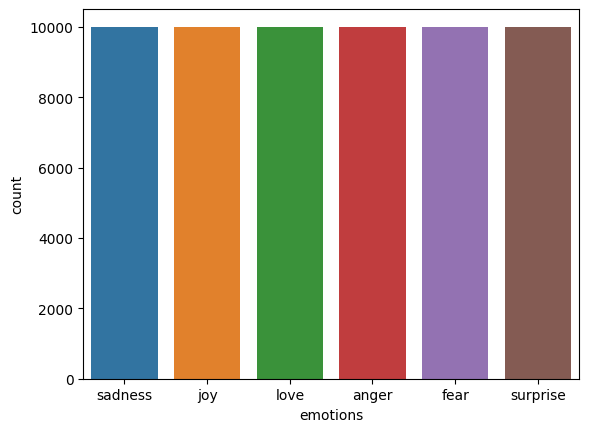

In [17]:
#Concated all the serparted data frames of all the emotions and but them back together
all_10k_df = pd.concat([sadness_df_10000, joy_df_10000, love_df_10000, anger_df_10000, fear_df_10000, surprise_df_10000])
sns.countplot(x=all_10k_df['emotions'])
plt.show()

In [18]:
#creating new column with cleaned up text
all_10k_df['cleaned_text'] = all_10k_df['text'].apply(clean_tweets_without_nlp)
print("Original text: ", all_10k_df.iloc[0]['text'])
print("Cleaned test: ", all_10k_df.iloc[0]['cleaned_text'])

Original text:  i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here
Cleaned test:  i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here


In [19]:
#creating new column with stemmed cleaned up text
all_10k_df['cleaned_text_stem'] = all_10k_df['text'].apply(clean_tweets_with_stem)
print("Original text: ", all_10k_df.iloc[0]['text'])
print("Stemmed test: ", all_10k_df.iloc[0]['cleaned_text_stem'])

Original text:  i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here
Stemmed test:  feel aw job get posit succeed happen


In [20]:
#creating new colum with lemmzed cleaned up text
all_10k_df['cleaned_text_lem'] = all_10k_df['text'].apply(clean_tweets_with_lem)
print("Original text: ", all_10k_df.iloc[0]['text'])
print("Lemmized test: ", all_10k_df.iloc[0]['cleaned_text_lem'])

Original text:  i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here
Lemmized test:  feel awful job get position succeed happen


# Testing with TfidfVectorizer and Multinomial Naive Bayes Classifier

cleaned_text
Mean Train Score 0.926
Mean Test Score 0.863


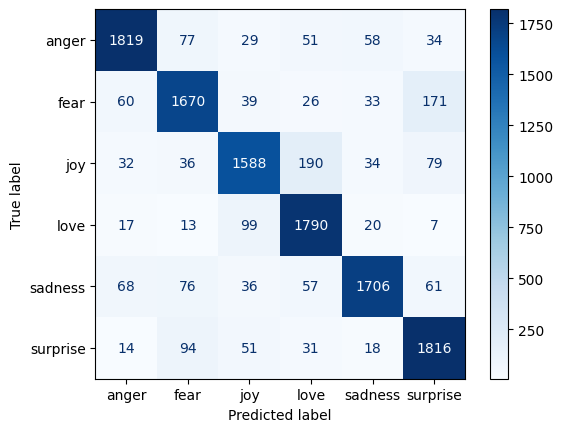

              precision    recall  f1-score   support

     sadness       0.90      0.88      0.89      2068
         joy       0.85      0.84      0.84      1999
        love       0.86      0.81      0.84      1959
       anger       0.83      0.92      0.88      1946
        fear       0.91      0.85      0.88      2004
    surprise       0.84      0.90      0.87      2024

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000




cleaned_text_stem
Mean Train Score 0.897
Mean Test Score 0.833


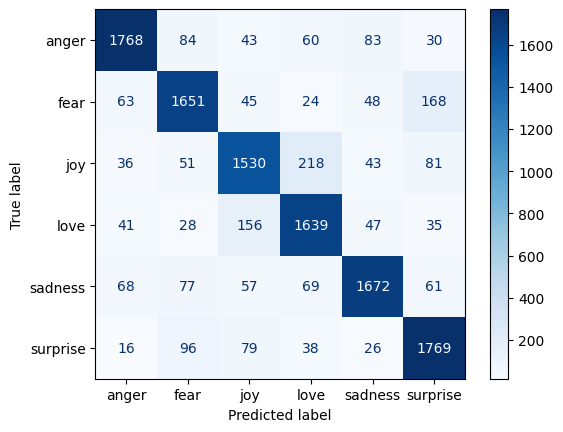

              precision    recall  f1-score   support

     sadness       0.89      0.85      0.87      2068
         joy       0.83      0.83      0.83      1999
        love       0.80      0.78      0.79      1959
       anger       0.80      0.84      0.82      1946
        fear       0.87      0.83      0.85      2004
    surprise       0.83      0.87      0.85      2024

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000




cleaned_text_lem
Mean Train Score 0.929
Mean Test Score 0.869


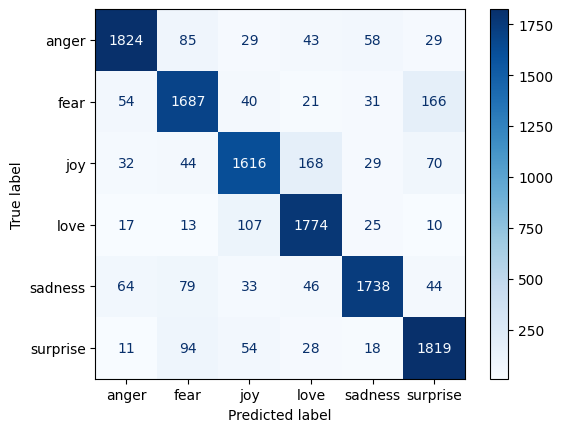

              precision    recall  f1-score   support

     sadness       0.91      0.88      0.90      2068
         joy       0.84      0.84      0.84      1999
        love       0.86      0.82      0.84      1959
       anger       0.85      0.91      0.88      1946
        fear       0.92      0.87      0.89      2004
    surprise       0.85      0.90      0.87      2024

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000






In [21]:
second_dataset_tfidf_models = []

for col in train_df.columns[2:]:

    print(col)

    X = all_10k_df[col].values
    y = all_10k_df['emotions'].values

    #Create model
    model = MultinomialNB()

    #Fit and Transform
    tfidf_vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.fit_transform(X)

    #Testing splits of 20% of dataset
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X, y, cv=kf, return_train_score=True)
    print("Mean Train Score", round(np.mean(cv_results["train_score"]),3))
    print("Mean Test Score", round(np.mean(cv_results["test_score"]),3))

    #split features and label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

    #Fit and predict
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    #Create confusion matrix for Tfid model
    cm = confusion_matrix(y_test, prediction, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    print(classification_report(y_test, prediction, target_names=['sadness','joy','love','anger','fear','surprise'], zero_division=1))
    print("\n\n")

    package = [model, tfidf_vectorizer]
    second_dataset_tfidf_models.append(package)

## Testing with Bag of Words Vectorizer and Multinomial Naive Bayes Classifier on Second Dataset

cleaned_text
Mean Train Score 0.928
Mean Test Score 0.859


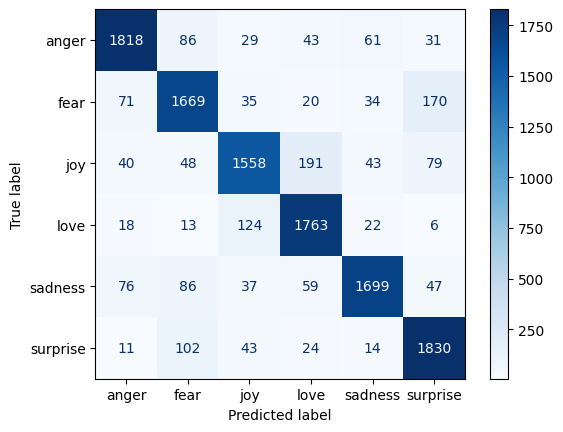

              precision    recall  f1-score   support

     sadness       0.89      0.88      0.89      2068
         joy       0.83      0.83      0.83      1999
        love       0.85      0.80      0.82      1959
       anger       0.84      0.91      0.87      1946
        fear       0.91      0.85      0.88      2004
    surprise       0.85      0.90      0.87      2024

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000




cleaned_text_stem
Mean Train Score 0.902
Mean Test Score 0.837


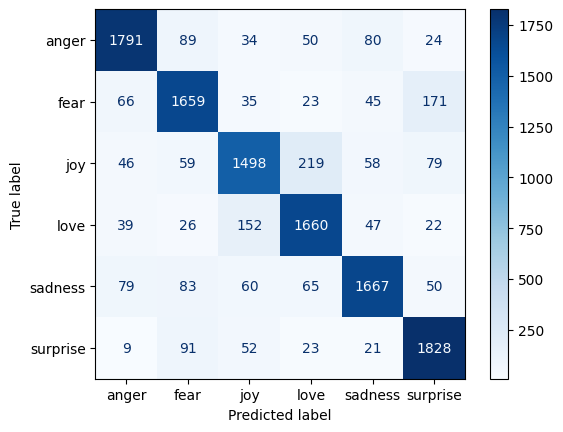

              precision    recall  f1-score   support

     sadness       0.88      0.87      0.87      2068
         joy       0.83      0.83      0.83      1999
        love       0.82      0.76      0.79      1959
       anger       0.81      0.85      0.83      1946
        fear       0.87      0.83      0.85      2004
    surprise       0.84      0.90      0.87      2024

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000




cleaned_text_lem
Mean Train Score 0.932
Mean Test Score 0.87


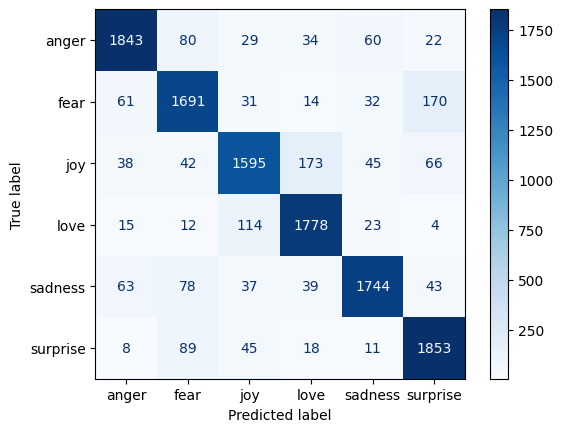

              precision    recall  f1-score   support

     sadness       0.91      0.89      0.90      2068
         joy       0.85      0.85      0.85      1999
        love       0.86      0.81      0.84      1959
       anger       0.86      0.91      0.89      1946
        fear       0.91      0.87      0.89      2004
    surprise       0.86      0.92      0.89      2024

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.87     12000
weighted avg       0.88      0.88      0.88     12000






In [22]:
Second_Dataset_BoW_models = []

for col in all_10k_df.columns[2:]:

    print(col)

    X = all_10k_df[col].values
    y = all_10k_df['emotions'].values

    #Create model
    model = MultinomialNB()

    #Fit and Transform
    BoW_vectorizer = CountVectorizer()
    X = BoW_vectorizer.fit_transform(X)

    #Testing splits of 20% of dataset
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X, y, cv=kf, return_train_score=True)
    print("Mean Train Score", round(np.mean(cv_results["train_score"]),3))
    print("Mean Test Score", round(np.mean(cv_results["test_score"]),3))

    #split features and label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

    #fit and predict
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Create confusion matrix for BOW model
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    #display metrics
    print(classification_report(y_test, model.predict(X_test), target_names=['sadness','joy','love','anger','fear','surprise'], zero_division=1))
    print("\n\n")

    package = [model, BoW_vectorizer]
    Second_Dataset_BoW_models.append(package)

# Conclusions

- Models with stemmed inputs witin context of the second dataset preformed the worst

- Fear and Joy labels have the lowest F1 score

# Best Models From Second Dataset

In [23]:
#TfidfVectorizer and Multinomial Naive Bayes Classifier
print("TfidfVectorizer on Second Dataset\n",classification_report(y_test,second_dataset_tfidf_models[2][0].predict(X_test)),"\n")

TfidfVectorizer on Second Dataset
               precision    recall  f1-score   support

       anger       0.91      0.89      0.90      2068
        fear       0.87      0.85      0.86      1999
         joy       0.90      0.81      0.85      1959
        love       0.86      0.93      0.90      1946
     sadness       0.93      0.87      0.90      2004
    surprise       0.85      0.95      0.90      2024

    accuracy                           0.88     12000
   macro avg       0.89      0.88      0.88     12000
weighted avg       0.89      0.88      0.88     12000
 



In [24]:
#Bag of Words Vectorizer and Multinomial Naive Bayes Classifier
print("Bag of Word Vectorizer on Second Dataset\n",classification_report(y_test,Second_Dataset_BoW_models[2][0].predict(X_test)),"\n")

Bag of Word Vectorizer on Second Dataset
               precision    recall  f1-score   support

       anger       0.91      0.89      0.90      2068
        fear       0.85      0.85      0.85      1999
         joy       0.86      0.81      0.84      1959
        love       0.86      0.91      0.89      1946
     sadness       0.91      0.87      0.89      2004
    surprise       0.86      0.92      0.89      2024

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.87     12000
weighted avg       0.88      0.88      0.88     12000
 



# Saving Best Model from Second Dataset

In [28]:
# save best model 
# pickle.dump(Second_Dataset_BoW_models[2][0], open('cleaned_BoW_MNB_88.pkl', 'wb'))

# save vectorizer
# pickle.dump(Second_Dataset_BoW_models[2][1], open('BoW_vectorizer_MNB_88.pkl', 'wb'))

TEST

In [25]:
best_model = Second_Dataset_BoW_models[2][0]
best_vec = Second_Dataset_BoW_models[2][1]

In [26]:
# test_scores = []
# train_scores = []

# df = new_df.copy()
# df['lem'] = df['text'].apply(clean_tweets_with_lem)

# for x in range(0, 100_001, 20_000):
#     df = df.iloc[:x]

#     X = df['lem'].values
#     y = df['emotions'].values
#     X = best_vec.fit_transform(X)

#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     cv_results = cross_validate(best_model, X, y, cv=kf, return_train_score=True)

#     test_scores.append(np.mean(cv_results["test_score"]))
#     train_scores.append(np.mean(cv_results["train_score"]))

In [27]:
# x = [n for n in range(0, 100_001, 20_000)]
# plt.plot(x, test_scores, label="test")
# plt.plot(x, train_scores, label="train")
# plt.show()